# Librerías

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.integrate import solve_ivp

# Instancia

In [2]:
PATH = '../voronoi/2K'
VERTEX_PATH = PATH + '/vertices.txt'
RIDGES_PATH = PATH + '/ridges.txt'
ORIS_PATH = PATH + '/oris.txt'
SE_PATH = PATH + '/SE/uniform.txt'
N_GRAINS = 10 #>=3
SEED = 123
DOMAIN_BOUND = 1.0
eps = 0.2


In [3]:
!python ../voronoi/voronoi.py $N_GRAINS $SEED $VERTEX_PATH $RIDGES_PATH $ORIS_PATH $SE_PATH

Vertices: 20
Ridges: 30
Orientations: 10
Using uniform distribution for SE
SE uniform: 10


In [4]:
ridges = np.loadtxt(RIDGES_PATH, dtype = int)
vertices = np.loadtxt(VERTEX_PATH)
oris = np.loadtxt(ORIS_PATH)
SE = np.loadtxt(SE_PATH)

# Funciones

In [5]:
def wrap_dist(dest, orig, DOMAIN_BOUND):
    delta = dest - orig
    if delta[0] > DOMAIN_BOUND*0.5:
        delta[0] = delta[0] - DOMAIN_BOUND
    elif delta[0] < -0.5*DOMAIN_BOUND:
        delta[0] = DOMAIN_BOUND + delta[0]
    if delta[1] > 0.5*DOMAIN_BOUND:
        delta[1] = delta[1] - DOMAIN_BOUND
    elif delta[1] < -0.5*DOMAIN_BOUND:
        delta[1] = DOMAIN_BOUND + delta[1]
    return delta

In [6]:
def _adjust_points(xpos, ypos, DOMAIN_BOUND):
    rang = len(xpos)
    xret = np.zeros(rang)
    yret = np.zeros(rang)
    xret[:] = xpos
    yret[:] = ypos
    for i in range(1, rang):
        curr = np.array([xret[i], yret[i]])
        prev = np.array([xret[i - 1], yret[i - 1]])
        delta = wrap_dist(curr, prev, DOMAIN_BOUND)
        curr = prev + delta
        xret[i] = curr[0]
        yret[i] = curr[1]
    return xret, yret

In [7]:
def plot_structure(boundarys, vertexs, domain=1.0, lw=1.0, figsize=(10, 7), vertex_plot=False):
    """
        Plot boundaries lines
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    coords = [bnd for bnd in boundarys]
    coords2 = [bnd+[domain,0] for bnd in boundarys if np.any(bnd[:,0] < 0)]
    coords3 = [bnd+[-domain,0] for bnd in boundarys if np.any(bnd[:,0] > domain)]
    coords4 = [bnd+[0,domain] for bnd in boundarys if np.any(bnd[:,1] < 0)]
    coords5 = [bnd+[0,-domain] for bnd in boundarys if np.any(bnd[:,1] > domain)]
    coords6 = [bnd+[domain,domain] for bnd in boundarys \
                if np.any(bnd[:,0] < 0) and np.any(bnd[:,1] < 0)]
    coords7 = [bnd+[-domain,-domain] for bnd in boundarys \
                if np.any(bnd[:,0] > domain) and np.any(bnd[:,1] > domain)]
    coords8 = [bnd+[-domain,domain] for bnd in boundarys \
                if np.any(bnd[:,0] > domain) and np.any(bnd[:,1] < 0)]
    coords9 = [bnd+[domain,-domain] for bnd in boundarys \
                if np.any(bnd[:,0] < 0) and np.any(bnd[:,1] > domain)]
    coords = coords+coords2+coords3+coords4+coords5+coords6+coords7+coords8+coords9
    bnd_collection = LineCollection(coords, lw=lw, color='k')
    ax.add_collection(bnd_collection)
    """
        Plot vertexs
    """
    if vertex_plot:
        plt.xlim(0., 1.)
        plt.ylim(0., 1.)
        plt.plot(vertexs[:,0], vertexs[:, 1], "ko", ms=1.0)
    return ax

In [8]:
def get_all_bounds_coords(ridges, vertices):
    boundarys = np.array([[[vertices[bound[0]][0], 
                        vertices[bound[0]][1]],
                       [vertices[bound[1]][0], 
                        vertices[bound[1]][1]]] for bound in ridges])
    return boundarys

In [9]:
def adjust_all_bounds(boundarys, bound_domain):
    boundarys_mod = np.zeros(boundarys.shape)
    for index, bound in enumerate(boundarys):
        ret = _adjust_points(bound[:,0], bound[:,1], bound_domain)
        boundarys_mod[index][:, 0] = ret[0]
        boundarys_mod[index][:, 1] = ret[1]
    return boundarys_mod

In [10]:
def compute_T(v_ini, v_fin, domain):
    dist = wrap_dist(v_fin, v_ini, domain)
    angle = np.arctan2(dist[1], dist[0])
    T_m = np.array([np.cos(angle), np.sin(angle)])
    return T_m

In [11]:
def get_neights_and_energys(vertex_n, vertex_association, ridges, bounds_energy):
    neights = {}
    for bound in vertex_association[vertex_n]:
        if ridges[bound][0] == vertex_n:
            neights[ridges[bound][1]] = bounds_energy[bound]
        else:
            neights[ridges[bound][0]] = bounds_energy[bound]
    return neights

In [12]:
"""
output: {verticei:boundi1, boundi2, boundi3, ..., verticen:boundn1, ...}
"""

def associate_all_bound_to_vertex(boundarys):
    vertex_association = {}
    for index, bound in enumerate(boundarys):
        v1, v2 = bound
        if v1 not in vertex_association:
            vertex_association[v1] = list()
        if v2 not in vertex_association:
            vertex_association[v2] = list()
        vertex_association[v1].append(index)
        vertex_association[v2].append(index)
    return vertex_association

In [13]:
def vertex_set_boundaries_clockwise(vertex_association, ridges, vertices, domain):
    for vertex in vertex_association:
        angle = np.zeros(3)
        for i in np.arange(3):
            ini_v = ridges[vertex_association[vertex][i]][0]
            end_v = ridges[vertex_association[vertex][i]][1]
            current = vertices[vertex]
            delta = wrap_dist(vertices[end_v], current, domain) if ini_v == vertex else wrap_dist(vertices[ini_v], current, domain)
            angle[i] = np.arctan2(delta[1], delta[0])
        for i in np.arange(2):
            for p in np.arange(1, 3-i):
                if angle[p-1] < angle[p]:
                    angle[p-1], angle[p] = angle[p], angle[p-1]
                    vertex_association[vertex][p-1], vertex_association[vertex][p] = vertex_association[vertex][p], vertex_association[vertex][p-1]

In [14]:
def find_vertex_pos(vertices, vertex):
    return np.where(np.all(vertices==vertex,axis=1))[0][0]

In [15]:
def generate_grains(n_vertices, vertex_association, ridges):
    lengrains = 0
    grains = dict()
    n_vertices = vertices.shape[0]
    considerated = np.full(3*n_vertices, False)
    for j in np.arange(n_vertices):
        start_v = j
        for g in np.arange(3):
            if not considerated[j*3 + g]:
                grain_vertex_list = list()
                current_v = start_v
                current_side = g
                while True:
                    j_idx = current_v
                    if considerated[j_idx * 3 + current_side]:
                        print("Error!!!!!!!!! MORIR PROGRAMA!")
                        input("Enter para confirmar que se sabe que murio programa.")
                    considerated[j_idx * 3 + current_side] = True
                    grain_vertex_list.append(current_v)
                    bnd = vertex_association[current_v][current_side]
                    current_v = ridges[bnd][1] if ridges[bnd][0] == current_v else ridges[bnd][0]
                    i = 0
                    while True:
                        if vertex_association[current_v][i] == bnd:
                            break
                        i+=1
                    current_side = (i+1) % 3
                    if current_v == start_v:
                        break
                grains[lengrains] = grain_vertex_list
                lengrains += 1
    if lengrains != N_GRAINS:
        print("No calzan los granos.")
    return grains

In [16]:
def bound_energy_func(d_alpha, eps):
    return 1. + 0.5*eps*(1. - np.power(np.cos(4.*d_alpha), 3.))

In [17]:
def associate_grains_to_vertex(grains):
    grains_of_vertex = {}
    for i in np.arange(N_GRAINS):
        for j in np.arange(len(grains[i])):
            actual_vertex = grains[i][j]
            if actual_vertex not in grains_of_vertex:
                grains_of_vertex[actual_vertex] = list()
            grains_of_vertex[actual_vertex].append(i)
    return grains_of_vertex

In [18]:
def compute_bounds_energy(ridges, grains_of_vertex, oris, eps):
    all_bounds_energy = np.zeros(ridges.shape[0])
    for bound_index, (v_ini, v_end) in enumerate(ridges):
        k = 0
        grains_id = [0,0]
        for i in np.arange(3):
            actual_grain = grains_of_vertex[v_ini][i]
            if actual_grain in grains_of_vertex[v_end]:
                grains_id[k] = actual_grain
                k += 1
                if k == 2:
                    break
        d_alpha = oris[grains_id[0]] - oris[grains_id[1]]
        all_bounds_energy[bound_index] = bound_energy_func(d_alpha, eps)       
    return all_bounds_energy

In [19]:
def ode_sys(t, coords, vertices, vertex_association, ridges, bounds_energy, domain, coor='x'):
    equations = []
    for index, vertex in enumerate(vertices):
        neights_and_energys = get_neights_and_energys(index, vertex_association, ridges, bounds_energy)
        res = np.zeros(2)
        for neight in neights_and_energys:
            T_neight = compute_T(vertices[index], vertices[neight], domain)
            energy_y = neights_and_energys[neight]
            res += T_neight*energy_y
        vertices[index] = res
        if coor == 'x':
            equations.append(res[0])
        else:
            equations.append(res[1])
    return equations

# Implementación

In [20]:
# Obtener todos los bounds ajustados con condiciones de borde periodicas
# boundarys_mod tiene la siguiente estructura:
"""
[[[inicio_vertex_x_1 inicio_vertex_y_1],
  [fin_vertex_x_1 fin_vertex_y_1]],
  [[inicio_vertex_x_2 inicio_vertex_y_2],
  [fin_vertex_x_2 fin_vertex_y_2]...]
  Donde 1 representa el boundary 1 (el que esta en la posicion 0 del array ridges).
  La estructura de datos contiene todos los boundarys.
"""
boundarys = get_all_bounds_coords(ridges, vertices)
boundarys_mod = adjust_all_bounds(boundarys, DOMAIN_BOUND)

In [21]:
# A cada vertice se le asocian 3 boundarys en sentido horario.
"""
Estructura de vertex_association:
{
    vertice_1:[bound_1, bound_2, bound_3],
    ...
    vertice_n:[bound_1, bound_2, bound_3]
}
donde vertice_1 es un indice, que representa el vertice en la posicion 0 de el array "vertices",
idem para bound_algo, son indices que representan la posicion en el array "ridges".
"""
vertex_association = associate_all_bound_to_vertex(ridges)
vertex_set_boundaries_clockwise(vertex_association, ridges, vertices, 1.0)

In [22]:
# A cada grano se le asocian vertices:
"""
Estructura de grains:
{
    grano_0:[vertice_1_0, vertice_2_0, ...],
    grano_1:[vertice_1_1, vertice_2_1, ...],
    ...
    grano_n:[vertice_1_n, vertice_2_n, ...]
}
Donde grano_i es un numero que representa a un grano, que coincide con el indice de el array 'oris', 
y vertice_algo_i representan los indices de los vertices asociados al grano i en el array 'vertices'.
"""
N_VERTICES = vertices.shape[0]
grains = generate_grains(N_VERTICES, vertex_association, ridges)

In [23]:
# A cada vertices se le asocian granos:
"""
Estructura de grains_of_vertex:
{
    vertice_0:[grano_0_0, grano_1_0, grano_2_0],
    vertice_1:[grano_1_1, grano_2_1, grano_3_1],
    ...
    vertice_n:[grano_1_n, grano_2_n, grano_3_n]
}
Donde vertice_i es un numero que representa a un vertice, que coincide con el indice de el array 'vertices', 
y grano_algo_i representan los indices de los granos, en 'oris'
"""
grains_of_vertex = associate_grains_to_vertex(grains)

In [24]:
# Calcular las energias de cada boundary:
"""
Estructura de bound_energy:
[energy_bound_0, energy_bound_1, ..., energy_bound_n]

"""
bounds_energy = compute_bounds_energy(ridges, grains_of_vertex, oris, eps)

In [25]:
import copy
t_begin=0.
t_end=5.
t_nsamples=100
t_space = np.linspace(t_begin, t_end, t_nsamples)
args = (vertices, vertex_association, ridges, bounds_energy, DOMAIN_BOUND, 'x')
method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
vertx_resp = copy.deepcopy(vertices)
num_sol_x = solve_ivp(ode_sys, [t_begin, t_end], vertices[:,0], method=method, args=args,dense_output=True)
args = (vertx_resp, vertex_association, ridges, bounds_energy, DOMAIN_BOUND, 'y')
num_sol_y = solve_ivp(ode_sys, [t_begin, t_end], vertx_resp[:,1], method=method, args=args,dense_output=True)

In [29]:
X_num_sol = num_sol_x.sol(t_space)
Y_num_sol = num_sol_y.sol(t_space)

# Plot section:

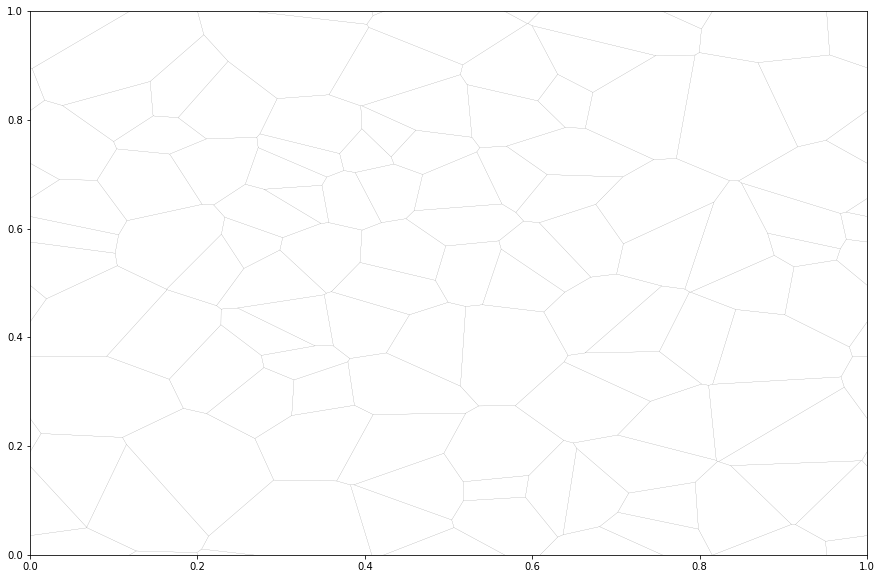

In [28]:
figsize = (15, 10)
LINE_WIDTH = 0.1
VERTEX_PLOT = False
ax = plot_structure(boundarys_mod, vertices, DOMAIN_BOUND, LINE_WIDTH, figsize, VERTEX_PLOT)

# Legacy code

In [17]:
def plot_grains(vertices, ridges, figsize=(10,7), vertex_plot = True, vertex_size = 3):
    plt.figure(figsize=figsize)
    vertex_total = vertices.shape[0]    
    # Quadrants for periodic boundary conditions
    quadrants = np.concatenate((
                                        vertices, # Quinto cuadrante
                                        vertices + [-1., 1.], # Primer cuadrante
                                        vertices + [0., 1.], # Segundo cuadrante
                                        vertices + [1., 1.], # Tercer cuadrante
                                        vertices + [-1., 0.], # Cuarto cuadrante
                                        vertices + [1., 0.], # Sexto cuadrante
                                        vertices + [-1., -1.], # Séptimo cuadrante
                                        vertices + [0., -1.], # Octavo cuadrante
                                        vertices + [1., -1.] # Noveno cuadrante
                                        ), axis=0)
    """
    ----------------------------------
             -             -
      1      -     2       -     3
    ----------------------------------
             -             -
      4      -     5       -     6
    ----------------------------------
             -             -
      7      -     8       -     9
    ----------------------------------
    """
    for vpair in ridges:
        v0 = vertices[vpair[0]]
        v1 = vertices[vpair[1]]
        """
            Heuristica que indica si 2 vertices estan conectados a traves de bordes.
            Si la distancia entre 2 vertices conectados es >= 0.5, estan conectados a traves de un borde.
        """
        if np.linalg.norm(v1-v0) < 0.5:   
            # Draw a line from v0 to v1.
            plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k', linewidth=0.5)
        else:
            min_v0 = (np.infty,-1)
            min_v1 = (np.infty,-1)
            # Se escoje el cuadrante con la menor distancia entre el par de vertices y se hace plot a 2 lineas.
            for vertex_number in range(vertex_total, quadrants.shape[0], vertex_total):
                norm_v0 = np.linalg.norm(quadrants[vertex_number + vpair[1]] - v0)
                norm_v1 = np.linalg.norm(quadrants[vertex_number + vpair[0]] - v1)
                if norm_v0 < min_v0[0]:
                    min_v0 = (norm_v0, vertex_number)
                if norm_v1 < min_v1[0]:
                    min_v1 = (norm_v1, vertex_number)
            plt.plot([v0[0], quadrants[min_v0[1] + vpair[1]][0]], [v0[1], quadrants[min_v0[1] + vpair[1]][1]], 'k', linewidth=0.5)
            plt.plot([v1[0], quadrants[min_v1[1] + vpair[0]][0]], [v1[1], quadrants[min_v1[1] + vpair[0]][1]], 'k', linewidth=0.5)
    # Se toma solo el plot de el quinto cuadrante.
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    # Mark the Voronoi vertices if vertex_plot = True.
    if vertex_plot:
        plt.plot(vertices[:,0], vertices[:, 1], "ko", ms=vertex_size)
    plt.show()

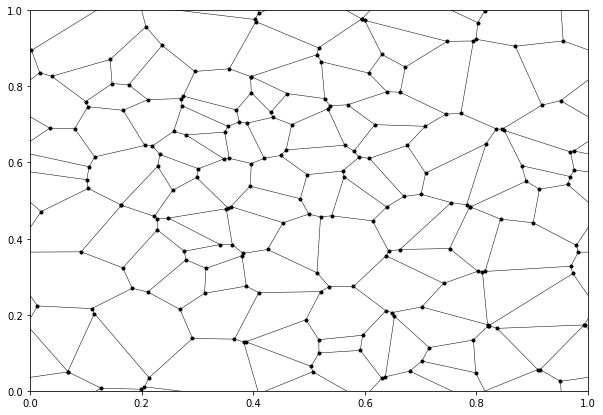

In [18]:
plot_grains(vertices, ridges)